# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';',error_bad_lines=False)

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info['missing_or_unknown_int'] = np.array('')
z = 0
for x,y in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    nan_values = y.strip('[]').split(',')
    new_nan_values = []
    if len(y) > 2:
        for c in nan_values:
            try:
                new_nan_values.append(int(c))
            except ValueError:                
                new_nan_values.append(c)
    feat_info['missing_or_unknown_int'][z] = new_nan_values
    z += 1

In [6]:
#replace the missing values with NaNs:
for x,y in zip(feat_info['attribute'],feat_info['missing_or_unknown_int']):
    for num in y: 
        azdias.loc[azdias[x] == num,x] = np.nan        
    try:
        azdias[x] = pd.to_numeric(azdias[x])
    except:
        print("Value {} is non-numeric".format(x))

Value OST_WEST_KZ is non-numeric
Value CAMEO_DEU_2015 is non-numeric


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([      0. ,   88906.1,  177812.2,  266718.3,  355624.4,  444530.5,
         533436.6,  622342.7,  711248.8,  800154.9,  889061. ]),
 <a list of 10 Patch objects>)

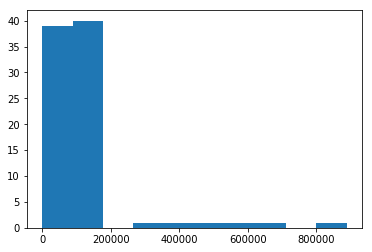

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_val = [azdias[x].isnull().sum() for x in feat_info['attribute']]
plt.hist(missing_val)

In [8]:
# Investigate patterns in the amount of missing data in each column.
feat_info['missing_val'] = np.array(missing_val)
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_int,missing_val
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]",685843
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]",2881
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]",0
3,CJT_GESAMTTYP,person,categorical,[0],[0],4854
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1],0


In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print("Dropping the columns...")
threshold = azdias.shape[0]*.2
dropped_column = []
for x in azdias:
    if azdias[x].isnull().sum() > threshold:
        print("Column {} ".format(x))
        dropped_column.append(x)

#dropping columns from the azdias
azdias.drop(dropped_column,axis =1, inplace=True)

#dropping columns from feature summary
for x in dropped_column:
    feat_info.drop(feat_info[feat_info['attribute'] == x].index[0],inplace = True)

print("Columns are dropped!")


Dropping the columns...
Column AGER_TYP 
Column GEBURTSJAHR 
Column TITEL_KZ 
Column ALTER_HH 
Column KK_KUNDENTYP 
Column KBA05_BAUMAX 
Columns are dropped!


(array([  1.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,  14.,   5.,  12.,
          0.,   6.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  10000.,   19750.,   29500.,   39250.,   49000.,   58750.,
          68500.,   78250.,   88000.,   97750.,  107500.,  117250.,
         127000.,  136750.,  146500.,  156250.,  166000.,  175750.,
         185500.,  195250.,  205000.,  214750.,  224500.,  234250.,
         244000.,  253750.,  263500.,  273250.,  283000.,  292750.,
         302500.,  312250.,  322000.,  331750.,  341500.,  351250.,
         361000.,  370750.,  380500.,  390250.,  400000.]),
 <a list of 40 Patch objects>)

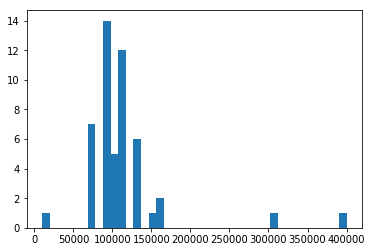

In [10]:
plt.hist(missing_val, bins=40, range= (10000,400000))

In [11]:
#display the missing values column wise
for x in azdias:
    count = azdias[x].isnull().sum()
    if count > 10000 and count < 400000:
        print("Column {} has {} missing values".format(x,count))    

Column HEALTH_TYP has 111196 missing values
Column LP_LEBENSPHASE_FEIN has 97632 missing values
Column LP_LEBENSPHASE_GROB has 94572 missing values
Column LP_FAMILIE_FEIN has 77792 missing values
Column LP_FAMILIE_GROB has 77792 missing values
Column NATIONALITAET_KZ has 108315 missing values
Column PRAEGENDE_JUGENDJAHRE has 108164 missing values
Column SHOPPER_TYP has 111196 missing values
Column SOHO_KZ has 73499 missing values
Column VERS_TYP has 111196 missing values
Column ANZ_PERSONEN has 73499 missing values
Column ANZ_TITEL has 73499 missing values
Column HH_EINKOMMEN_SCORE has 18348 missing values
Column W_KEIT_KIND_HH has 147988 missing values
Column WOHNDAUER_2008 has 73499 missing values
Column ANZ_HAUSHALTE_AKTIV has 99611 missing values
Column ANZ_HH_TITEL has 97008 missing values
Column GEBAEUDETYP has 93148 missing values
Column KONSUMNAEHE has 73969 missing values
Column MIN_GEBAEUDEJAHR has 93148 missing values
Column OST_WEST_KZ has 93148 missing values
Column WOHNLA

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The above cell clearly displays the missing data from each cell which has missing values between range (10000,400000). 
Columns which has more than 80% of missing data has been removed. Below is the list of columns which were removed:
AGER_TYP 
GEBURTSJAHR 
TITEL_KZ 
ALTER_HH 
KK_KUNDENTYP 
KBA05_BAUMAX 

If we observe the missing value list from the above cell there is uniformity between the count of missing values between the same groups. For example all the micro cell columns whose name starts with "KBA05" has 133324 missing values and macrocells name starting with PLZ8 has missing value of 116515.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
azdias['missing_row_counts'] = azdias.isnull().sum(axis = 1)

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_missing_values = pd.DataFrame(azdias.loc[azdias['missing_row_counts']>=11])
azdias_non_missing = pd.DataFrame(azdias.loc[azdias['missing_row_counts'] < 11])

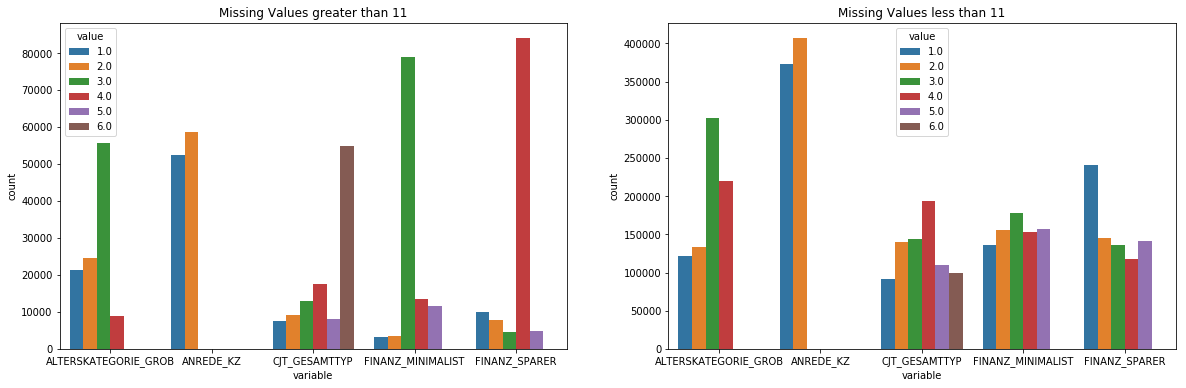

In [14]:
fig, ax =plt.subplots(1,2,figsize=(20,6))
ax[0].set_title('Missing Values greater than 11')
ax[1].set_title('Missing Values less than 11')
sns.countplot(ax = ax[0],x = "variable", hue = "value", data=pd.melt(azdias_missing_values[['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER']]))
sns.countplot(ax = ax[1],x = "variable", hue = "value", data=pd.melt(azdias_non_missing[['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER']]))

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias_missing_values_count = azdias_missing_values.shape[0]
azdias_non_missing_count = azdias_non_missing.shape[0]

cols = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER']

for x in cols:
    missing_counts = azdias_missing_values[x].isnull().sum()
    non_missing_counts = azdias_non_missing[x].isnull().sum()
    print("Column {} has {}% missing value and {}% non missing value.".format(x,missing_counts/azdias_missing_values_count *100, non_missing_counts/azdias_non_missing_count * 100))

Column ALTERSKATEGORIE_GROB has 0.23048942989880072% missing value and 0.336472461171078% non missing value.
Column ANREDE_KZ has 0.0% missing value and 0.0% non missing value.
Column CJT_GESAMTTYP has 0.9183563222530342% missing value and 0.4914420632875859% non missing value.
Column FINANZ_MINIMALIST has 0.0% missing value and 0.0% non missing value.
Column FINANZ_SPARER has 0.0% missing value and 0.0% non missing value.


#### Discussion 1.1.3: Assess Missing Data in Each Row

Data with more missing values has lots of missing data compare to less missing data from second part. The above bar graph clearly depicts this information for the first five rows. Also the we can see this the first part has mroe % of missing data compare to second part.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
feat_info.head(1)

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_int,missing_val
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]",2881


In [17]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [18]:
#grab the categrical attributes 
categorical_attributes = feat_info[feat_info['type']=='categorical']['attribute']
categorical_attributes

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [19]:
#count the values from each category
for category in categorical_attributes:
    print(azdias[category].value_counts())

2.0    465305
1.0    425916
Name: ANREDE_KZ, dtype: int64
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6.0    290367
1.0    199572
4.0    130625
2.0    110867
5.0    106436
3.0     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0   

##### Categories that need addressing prior to one-hot encoding #####

Before moving forward to the Re-Encode Categorical Features we need to address the columns which has non-numeric values. Here column name "OST_WEST_KZ" has binary non-numeric value 'W' and 'O'. And column "CAMEO_DEU_2015" also has non-numerical and non-binary value.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#encode the OST_WEST_KZ column values as 'O' = 0 and 'W' = 1
azdias.loc[azdias['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 0
azdias.loc[azdias['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 1

In [21]:
#check the 'OST_WEST_KZ' column values
azdias['OST_WEST_KZ'][1:6]

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: object

In [22]:
#check the data in 'CAMEO_DEU_2015' column before encoding
azdias['CAMEO_DEU_2015'][1:5]

1    8A
2    4C
3    2A
4    6B
Name: CAMEO_DEU_2015, dtype: object

In [23]:
#change the values of column "CAMEO_DEU_2015" to numeric values
le = LabelEncoder()
azdias['CAMEO_DEU_2015_ENCODED'] = le.fit_transform(azdias['CAMEO_DEU_2015'].astype(str))

In [24]:
#drop non-numeric columns from the dataset and categorial attributes list
azdias.drop(['CAMEO_DEU_2015'],axis = 1, inplace = True)
categorical_attributes.drop(categorical_attributes[categorical_attributes=='CAMEO_DEU_2015'].index[0])

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
Name: attribute, dtype: object

In [25]:
#check the data in 'CAMEO_DEU_2015' column after encoding (column name changed)
azdias['CAMEO_DEU_2015_ENCODED'][1:6]

1    35
2    15
3     5
4    25
5    37
Name: CAMEO_DEU_2015_ENCODED, dtype: int64

- Now both the non-neumeric column values has been encoded we can proceed with Re-Encode Features section

In [26]:
azdias.tail(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_row_counts,CAMEO_DEU_2015_ENCODED
891216,3.0,2.0,5.0,1.0,4.0,2.0,5.0,4.0,4.0,1.0,...,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,3,30
891217,2.0,1.0,4.0,3.0,3.0,3.0,2.0,2.0,3.0,6.0,...,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,4,42
891218,2.0,2.0,4.0,2.0,4.0,2.0,5.0,4.0,3.0,1.0,...,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,5,15
891219,1.0,1.0,3.0,1.0,5.0,3.0,5.0,5.0,5.0,1.0,...,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,0,42
891220,4.0,1.0,1.0,4.0,2.0,5.0,2.0,1.0,5.0,6.0,...,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0,0,25


In [27]:
#check the shape of azdias before OneHotEncoding 
azdias.shape

(891221, 80)

In [28]:
# Re-encode categorical variable(s) to be kept in the analysis
enc = OneHotEncoder()
filler = 999

for x in categorical_attributes:
    if x in azdias.columns and len(azdias[x].value_counts()) > 2:
        azdias[x] = azdias[x].fillna(filler)
        encode = enc.fit_transform(azdias[x].values.reshape(-1,1)).toarray()
        oneHot_df = pd.DataFrame(encode, columns = [x + '_' + str(int(i+1)) for i in range(encode.shape[1])])
        
        #concatenate this column to azdias and drop the existing column
        azdias = pd.concat([azdias,oneHot_df], axis = 1)
        azdias.drop(x, axis=1, inplace = True)

In [29]:
azdias.shape

(891221, 162)

In [30]:
azdias.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_10
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features


All the categorial value columns has been identfied and encoded accordingly. Categorical binary values with alphabatical labeling has been encoded by replacing with Integer value. Others are ecoded usign OneHotEncode method. 

After performing all the above steps now all the values are in Integers and much more sparse than earlier.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_info['type'].value_counts()

mixed_attributes = feat_info[feat_info['type'] == 'mixed']['attribute']
mixed_attributes

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [32]:
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [33]:
with open('Data_Dictionary.md','r') as f:
    data_dict = f.read()
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [34]:
#create these varible from the Data_Dictionary.md for PRAEGENDE_JUGENDJAHRE
decade = [40,50.60,70,80,90]
movement = [[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,5]]
mainstream = [1,3,5,8,10,12,14]
avantgrade = [2,4,6,7,9,11,13,15]


In [35]:
#create a PRAEGENDE_JUGENDJAHRE_DECADE column from PRAEGENDE_JUGENDJAHRE
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = np.array(np.nan)

for x,y in zip(decade,movement):
    azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(y),'PRAEGENDE_JUGENDJAHRE_DECADE'] = x

azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts()

80.0    179558
90.0    151770
70.0    116078
50.6     75646
40.0     28761
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [36]:
#create a PRAEGENDE_JUGENDJAHRE_MOVEMENT column from PRAEGENDE_JUGENDJAHRE
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.array(np.nan)

#for x,y in zip(mainstream,avantgrade):
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(mainstream),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(avantgrade),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1

azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts()

0.0    607832
1.0    175225
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [37]:
#drop the original column
azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace = True)

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [38]:
azdias['CAMEO_INTL_2015'].value_counts()

51.0    133694
41.0     92336
24.0     91158
14.0     62884
43.0     56672
54.0     45391
25.0     39628
22.0     33155
23.0     26750
13.0     26336
45.0     26132
55.0     23955
52.0     20542
31.0     19024
34.0     18524
15.0     16974
44.0     14820
12.0     13249
35.0     10356
32.0     10354
33.0      9935
Name: CAMEO_INTL_2015, dtype: int64

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealthy = [11,12,13,14,15]
prosperous = [21,22,23,24,25]
comfortable = [31,32,33,34,35]
less = [41,42,43,44,45]
poorer = [51,52,53,54,55]

w_stage = [wealthy,prosperous,comfortable,less,poorer]
w_loc = [1,2,3,4,5]

pre_family = [11,21,31,41,51]
young_couples = [12,22,32,42,52]
families = [13,23,33,43,53]
older_families = [14,24,34,44,54]
elders = [15,25,35,45,55]
f_stage = [pre_family,young_couples,families,older_families,elders]
f_loc = [1,2,3,4,5]

azdias['CAMEO_INTL_2015_WEALTH'] = np.array(np.nan)
azdias['CAMEO_INTL_2015_LIFE'] = np.array(np.nan)

for x,y in zip(w_stage,w_loc):
    azdias.loc[azdias['CAMEO_INTL_2015'].isin(x),'CAMEO_INTL_2015_WEALTH'] = y

for i,j in zip(f_stage,f_loc):
    azdias.loc[azdias['CAMEO_INTL_2015'].isin(i),'CAMEO_INTL_2015_LIFE'] = j

In [40]:
#drop the original column 'CAMEO_INTL_2015'
azdias.drop('CAMEO_INTL_2015',axis = 1, inplace = True)

In [41]:
print(azdias['CAMEO_INTL_2015_WEALTH'].value_counts())
print(azdias['CAMEO_INTL_2015_LIFE'].value_counts())

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: CAMEO_INTL_2015_WEALTH, dtype: int64
1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: CAMEO_INTL_2015_LIFE, dtype: int64


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Mixed type coulmns have multiple values clubbed into one. We need to seperate these values by creating multiple columns. After creating segregating these columns, original columns has been removed from the dataset.

Here for column PRAEGENDE_JUGENDJAHRE two new columns with suffix DECADE and MOVEMENT has been created. To seperate this I have utilised Data_Dictionary.md file to identify values. Similar technique is applied with column CAMEO_INTL_2015

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
for x in azdias.columns:
    if azdias[x].isnull().sum() > 100000:
        print("Column {} has more missing values".format(x))

Column HEALTH_TYP has more missing values
Column VERS_TYP has more missing values
Column W_KEIT_KIND_HH has more missing values
Column KBA05_ANTG1 has more missing values
Column KBA05_ANTG2 has more missing values
Column KBA05_ANTG3 has more missing values
Column KBA05_ANTG4 has more missing values
Column KBA05_GBZ has more missing values
Column KKK has more missing values
Column MOBI_REGIO has more missing values
Column REGIOTYP has more missing values
Column KBA13_ANZAHL_PKW has more missing values
Column PLZ8_ANTG1 has more missing values
Column PLZ8_ANTG2 has more missing values
Column PLZ8_ANTG3 has more missing values
Column PLZ8_ANTG4 has more missing values
Column PLZ8_BAUMAX has more missing values
Column PLZ8_HHZ has more missing values
Column PLZ8_GBZ has more missing values
Column PRAEGENDE_JUGENDJAHRE_DECADE has more missing values
Column PRAEGENDE_JUGENDJAHRE_MOVEMENT has more missing values


In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_10,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,80.0,0.0,4.0,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info['missing_or_unknown_int'] = np.array('')
    z = 0
    for x,y in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
        nan_values = y.strip('[]').split(',')
        new_nan_values = []
        if len(y) > 2:
            for c in nan_values:
                try:
                    new_nan_values.append(int(c))
                except ValueError:
                    new_nan_values.append(c)
        feat_info['missing_or_unknown_int'][z] = new_nan_values
        z += 1
    
    for x,y in zip(feat_info['attribute'],feat_info['missing_or_unknown_int']):
        for num in y:
            df.loc[df[x] == num,x] = np.nan        
        try:
            df[x] = pd.to_numeric(df[x])
        except:
            print("Value {} is non-numeric".format(x))
    
    # remove selected columns and rows, ...
    print("Dropping the columns...")
    threshold = df.shape[0]*.4
    dropped_column = []
    for x in df:
        if df[x].isnull().sum() > threshold:
            print("Column {} ".format(x))
            dropped_column.append(x)

    df.drop(dropped_column,axis =1, inplace=True)

    for x in dropped_column:
        feat_info.drop(feat_info[feat_info['attribute'] == x].index[0],inplace = True)

    print("Columns are dropped!")
    
    # select, re-encode, and engineer column values.
    categorical_attributes = feat_info[feat_info['type']=='categorical']['attribute']

    #encode the OST_WEST_KZ column values as 'O' = 0 and 'W' = 1
    df.loc[df['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 0
    df.loc[df['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 1

        #change the values of column "CAMEO_DEU_2015" to numeric values
    le = LabelEncoder()
    df['CAMEO_DEU_2015_ENCODED'] = le.fit_transform(df['CAMEO_DEU_2015'].astype(str))

        #drop non-numeric columns from the dataset and categorial attributes list
    df.drop(['CAMEO_DEU_2015'],axis = 1, inplace = True)
    categorical_attributes.drop(categorical_attributes[categorical_attributes=='CAMEO_DEU_2015'].index[0])

        # Re-encode categorical variable(s) to be kept in the analysis
    enc = OneHotEncoder()
    filler = 999

    for x in categorical_attributes:
        if x in df.columns and len(df[x].value_counts()) > 2:
            df[x] = df[x].fillna(filler)
            encode = enc.fit_transform(df[x].values.reshape(-1,1)).toarray()
            oneHot_df = pd.DataFrame(encode, columns = [x + '_' + str(int(i+1)) for i in range(encode.shape[1])])

            #concatenate this column to df and drop the existing column
            df = pd.concat([df,oneHot_df], axis = 1)
            df.drop(x, axis=1, inplace = True)


    decade = [40,50.60,70,80,90]
    movement = [[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,5]]
    mainstream = [1,3,5,8,10,12,14]
    avantgrade = [2,4,6,7,9,11,13,15]
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = np.array(np.nan)

    for x,y in zip(decade,movement):
        df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(y),'PRAEGENDE_JUGENDJAHRE_DECADE'] = x

    df['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts()

    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.array(np.nan)

    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(avantgrade),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1

    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts()
    df.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace = True)

    wealthy = [11,12,13,14,15]
    prosperous = [21,22,23,24,25]
    comfortable = [31,32,33,34,35]
    less = [41,42,43,44,45]
    poorer = [51,52,53,54,55]

    w_stage = [wealthy,prosperous,comfortable,less,poorer]
    w_loc = [1,2,3,4,5]

    pre_family = [11,21,31,41,51]
    young_couples = [12,22,32,42,52]
    families = [13,23,33,43,53]
    older_families = [14,24,34,44,54]
    elders = [15,25,35,45,55]
    f_stage = [pre_family,young_couples,families,older_families,elders]
    f_loc = [1,2,3,4,5]

    df['CAMEO_INTL_2015_WEALTH'] = np.array(np.nan)
    df['CAMEO_INTL_2015_LIFE'] = np.array(np.nan)

    for x,y in zip(w_stage,w_loc):
        df.loc[df['CAMEO_INTL_2015'].isin(x),'CAMEO_INTL_2015_WEALTH'] = y

    for i,j in zip(f_stage,f_loc):
        df.loc[df['CAMEO_INTL_2015'].isin(i),'CAMEO_INTL_2015_LIFE'] = j

    df.drop('CAMEO_INTL_2015',axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
azdias.shape

(891221, 164)

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
def impute_df(df):
    imputed_df = pd.DataFrame(df)
    
    for col in imputed_df.columns:
        imputed = Imputer(missing_values = 'NaN', strategy = 'mean', axis =0)
        imputed_df[col] = imputed.fit_transform(df[col].values.reshape(-1,1))
    
    return imputed_df

In [47]:
azdias_imputed = impute_df(azdias)
azdias_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_10,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,2.190129,...,0.0,0.0,0.0,0.0,0.0,1.0,74.53164,0.22377,3.262098,2.873033
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,74.53164,0.00000,5.000000,1.000000
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,74.53164,1.00000,2.000000,4.000000
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,80.00000,0.00000,1.000000,2.000000
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,80.00000,0.00000,4.000000,3.000000


In [48]:
# Apply feature scaling to the general population demographics data.
def feature_scaling(df):
    scaled_df = pd.DataFrame(df)
    
    for col in scaled_df.columns:
        scaler = StandardScaler()
        scaled_df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
    
    return scaled_df

In [49]:
azdias_scaled = feature_scaling(azdias_imputed)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_10,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,-0.750972,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.000000,...,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,2.823179,-3.648482e-15,-1.420953e-16,3.216984e-16,6.346104e-16
1,-1.742724,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,1.146266,...,-0.25723,-0.367167,-0.309555,2.372570,-0.371684,-0.354211,-3.648482e-15,-5.727990e-01,1.258937e+00,-1.338297e+00
2,0.240781,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,1.146266,...,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,-0.354211,-3.648482e-15,1.986963e+00,-9.142640e-01,8.052265e-01
3,1.232533,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.269102,...,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,-0.354211,4.679806e-01,-5.727990e-01,-1.638664e+00,-6.237891e-01
4,0.240781,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,1.146266,...,-0.25723,2.723555,-0.309555,-0.421484,-0.371684,-0.354211,4.679806e-01,-5.727990e-01,5.345367e-01,9.071870e-02


### Discussion 2.1: Apply Feature Scaling


To impute the missing data I haved used the strategy as "mean". After applying the imputation on the dataframe object an obeject azdias_imputed is created. This object is again passed to the feature_scaling() function which is created to scale the values of the columns.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit(azdias_scaled)
azdias_trans = azdias_pca.transform(azdias_scaled)
variance = azdias_pca.explained_variance_ratio_

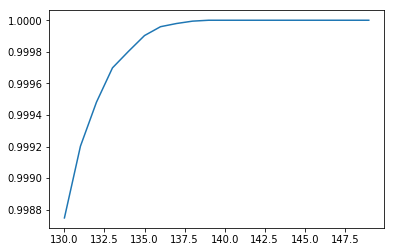

In [51]:
# Investigate the variance accounted for by each principal component.
components = []
variance_acct = []

for x in range(130,150,1):
    variance_acct.append(sum(variance[0:x+1]))
    components.append(x)
plt.plot(components,variance_acct);

In [52]:
#create a scree_plot function. This function is a copy from helper_funcitons.py 
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=20)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [53]:
azdias_scaled.shape

(891221, 164)

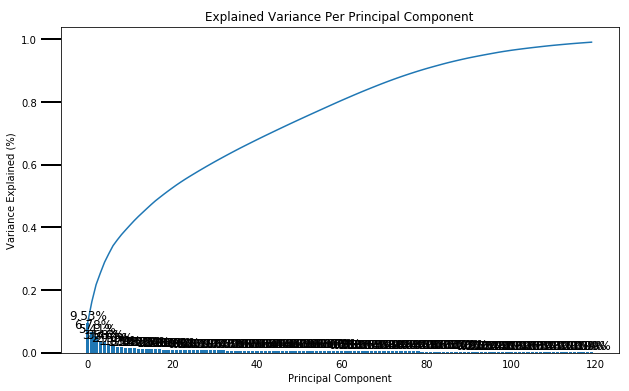

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(120)
azdias_pca = pca.fit(azdias_scaled)
azdias_trans = azdias_pca.transform(azdias_scaled)

#Create scree plot associated with the principal components 
scree_plot(azdias_pca)

In [55]:
azdias_trans.shape

(891221, 120)

### Discussion 2.2: Perform Dimensionality Reduction

After performing the dimensionality reduction almost 25% of the fetures has been reduced. Before performing dimensionality reduction the object has 164 columns and now it only has 120

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [80]:
azdias_copy = azdias.copy()

In [78]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(df, pca, n_component=1):

    dimension = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimension
    n_component = components.iloc[n_component-1]

    # The results
    print("Most Positive Values\n\n", n_component.sort_values(ascending=False)[:10])
    print("\nMost Negative Values\n\n", n_component.sort_values(ascending=True)[:10])

In [81]:
# For the first component
map_weights(azdias_copy, pca, 1)

Most Positive Values

 PLZ8_ANTG3                0.1824
CAMEO_INTL_2015_WEALTH    0.1815
LP_STATUS_GROB_1          0.1802
PLZ8_ANTG4                0.1772
CAMEO_DEU_2015_ENCODED    0.1742
PLZ8_BAUMAX               0.1729
ORTSGR_KLS9               0.1563
EWDICHTE                  0.1546
HH_EINKOMMEN_SCORE        0.1530
FINANZ_HAUSBAUER          0.1464
Name: Dimension 1, dtype: float64

Most Negative Values

 MOBI_REGIO            -0.2020
KBA05_ANTG1           -0.1887
PLZ8_ANTG1            -0.1829
KBA05_GBZ             -0.1795
FINANZ_MINIMALIST     -0.1791
LP_LEBENSPHASE_FEIN   -0.1407
KONSUMNAEHE           -0.1360
PLZ8_GBZ              -0.1341
INNENSTADT            -0.1283
LP_LEBENSPHASE_GROB   -0.1277
Name: Dimension 1, dtype: float64


In [82]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(azdias_copy, pca, 2) 

Most Positive Values

 ALTERSKATEGORIE_GROB    0.1846
FINANZ_VORSORGER        0.1770
NATIONALITAET_KZ_1      0.1611
SEMIO_ERL               0.1442
RETOURTYP_BK_S          0.1242
HH_EINKOMMEN_SCORE      0.1097
SEMIO_VERT              0.1088
FINANZTYP_5             0.1056
W_KEIT_KIND_HH          0.1044
LP_STATUS_FEIN_1        0.1042
Name: Dimension 2, dtype: float64

Most Negative Values

 FINANZ_UNAUFFAELLIGER   -0.2327
FINANZ_ANLEGER          -0.2284
SEMIO_REL               -0.2125
FINANZ_SPARER           -0.2099
missing_row_counts      -0.1961
FINANZTYP_4             -0.1861
GEBAEUDETYP_8           -0.1830
NATIONALITAET_KZ_4      -0.1819
SHOPPER_TYP_5           -0.1805
CAMEO_DEUG_2015_10      -0.1790
Name: Dimension 2, dtype: float64


In [83]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(azdias_copy, pca, 3) 

Most Positive Values

 ZABEOTYP_3            0.2381
missing_row_counts    0.2008
SEMIO_KRIT            0.1929
GEBAEUDETYP_8         0.1929
CAMEO_DEUG_2015_10    0.1880
NATIONALITAET_KZ_4    0.1822
SHOPPER_TYP_5         0.1801
SEMIO_KAEM            0.1662
LP_FAMILIE_GROB_6     0.1623
LP_FAMILIE_FEIN_12    0.1623
Name: Dimension 3, dtype: float64

Most Negative Values

 SEMIO_KULT          -0.2317
SEMIO_TRADV         -0.1952
SEMIO_SOZ           -0.1797
SEMIO_VERT          -0.1732
ONLINE_AFFINITAET   -0.1375
SEMIO_PFLICHT       -0.1293
FINANZTYP_1         -0.1233
ZABEOTYP_4          -0.1183
FINANZ_SPARER       -0.1177
SEMIO_FAM           -0.1119
Name: Dimension 3, dtype: float64


### Discussion 2.3: Interpret Principal Components


The above list clearly displays the weights of the 3 principle components for most Positive/Negative values.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
# Over a number of different cluster counts...
clusters = []
distances = []

for x in range(1,30,3):
    kmeans = KMeans(x)       

    print("Fitting KMeans...")
    # run k-means clustering on the data and...
    kmeans.fit(azdias_trans)
    
    print("Computing score value...")
    # compute the average within-cluster distances.
    score = kmeans.score(azdias_trans)
    
    #create the list of cluster and distances
    clusters.append(x)
    distances.append(score)
    print("For x = {}, value of score = {}".format(x,score))

Fitting KMeans...
Computing score value...
For x = 1, value of score = -144813175.1519715
Fitting KMeans...
Computing score value...
For x = 4, value of score = -122386564.42468582
Fitting KMeans...
Computing score value...
For x = 7, value of score = -113193275.11471242
Fitting KMeans...
Computing score value...
For x = 10, value of score = -108622743.03930706
Fitting KMeans...
Computing score value...
For x = 13, value of score = -105636606.80684716
Fitting KMeans...
Computing score value...
For x = 16, value of score = -103197783.9032207
Fitting KMeans...
Computing score value...
For x = 19, value of score = -100400422.25799204
Fitting KMeans...
Computing score value...
For x = 22, value of score = -97712788.36436021
Fitting KMeans...
Computing score value...
For x = 25, value of score = -96066004.39726608
Fitting KMeans...
Computing score value...
For x = 28, value of score = -93829536.91349725


Cluster 1 has distance as: -144813175.1519715
Cluster 4 has distance as: -122386564.42468582
Cluster 7 has distance as: -113193275.11471242
Cluster 10 has distance as: -108622743.03930706
Cluster 13 has distance as: -105636606.80684716
Cluster 16 has distance as: -103197783.9032207
Cluster 19 has distance as: -100400422.25799204
Cluster 22 has distance as: -97712788.36436021
Cluster 25 has distance as: -96066004.39726608
Cluster 28 has distance as: -93829536.91349725


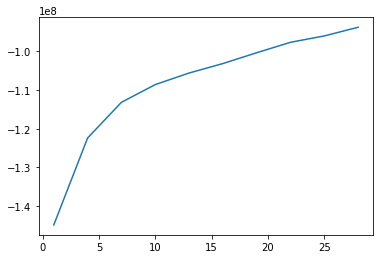

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
for x,y in zip(clusters,distances):
    print("Cluster {} has distance as: {}".format(x,y))

plt.plot(clusters,distances)

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(10)
kmeans = kmeans.fit(azdias_trans)
k_pred = kmeans.predict(azdias_trans)

In [63]:
general_pred = k_pred

In [64]:
print("Prediction vlaue = {}".format(k_pred))
print("Count of demorgraphics data is {} and its prediction count is {}".format(len(azdias_trans),len(azdias_trans),len(k_pred)))

Prediction vlaue = [1 5 0 ..., 0 8 9]
Count of demorgraphics data is 891221 and its prediction count is 891221


### Discussion 3.1: Apply Clustering to General Population

We can see from above graph that there is bend near point 4 and then there is slight lite bend near 10. From 10 onwards there is gradually increase in the score and also the computation time is increasing. With the understanding from thegraph 10 seems to be good number for clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [65]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', ';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_impute = impute_df(customers_clean)
customers_scaled = feature_scaling(customers_impute)

Value OST_WEST_KZ is non-numeric
Value CAMEO_DEU_2015 is non-numeric
Dropping the columns...
Column AGER_TYP 
Column GEBURTSJAHR 
Column TITEL_KZ 
Column KK_KUNDENTYP 
Column KBA05_BAUMAX 
Columns are dropped!


In [67]:
customers_scaled.shape

(191652, 163)

In [68]:
#adding a dummy column to the customers data so the shape match from azdias_pca
customers_scaled['Dummy_column'] = np.array(0)

In [69]:
customers_scaled.shape

(191652, 164)

In [70]:
customers_trans = azdias_pca.transform(customers_scaled)
customer_pred = kmeans.predict(customers_trans)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

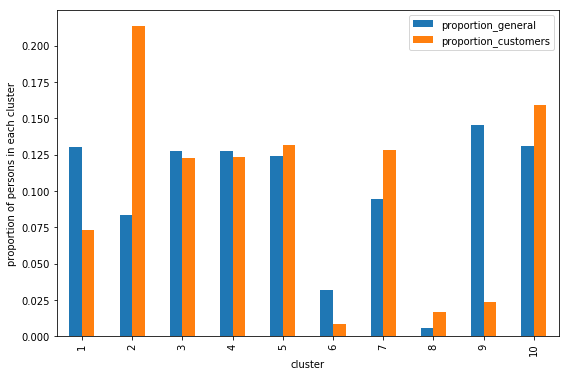

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_prop = []
customers_prop = []
x = [i+1 for i in range(10)]
for i in range(10):
    general_prop.append((general_pred == i).sum()/len(general_pred))
    customers_prop.append((customer_pred == i).sum()/len(customer_pred))


df_general = pd.DataFrame({'cluster' : x, 'proportion_general' : general_prop, 'proportion_customers':customers_prop})

df_general.plot(x='cluster', y = ['proportion_general', 'proportion_customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [94]:
#identify the centers of the clusters
centers = kmeans.cluster_centers_
centers.shape

(10, 120)

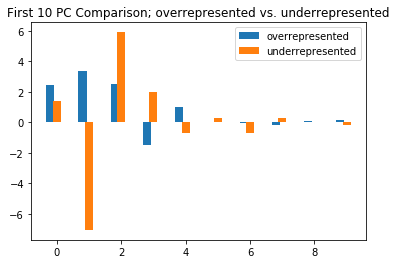

In [105]:
center_points = np.arange(0,10)

ax1 = plt.subplot(111)
ax1.bar(center_points - 0.2,centers[3][0:10], width = 0.25)
ax1.bar(center_points,centers[1][0:10], width = 0.25)
ax1.set_title('First 10 PC Comparison; overrepresented vs. underrepresented')
plt.legend(['overrepresented','underrepresented'])
plt.show()

In [130]:
centers_reverse = azdias_pca.inverse_transform(centers)
centers_df = pd.DataFrame(centers_reverse, columns = azdias_scaled.columns)
over = centers_df.loc[3]
under = centers_df.loc[1]

In [135]:

watch = ['ZABEOTYP_6','GEBAEUDETYP_7','CAMEO_DEU_2015_ENCODED','MOBI_REGIO','NATIONALITAET_KZ_1','LP_STATUS_GROB_1','PLZ8_ANTG3','PLZ8_ANTG4','ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER']

In [136]:
print("Feature.......Overrepresented.......Underrepresented")
for x in watch:
    print(f"{x}.......{over[x]}.......{under[x]}")

Feature.......Overrepresented.......Underrepresented
ZABEOTYP_6.......-0.021196284045079797.......-0.2931789182759815
GEBAEUDETYP_7.......0.1551494093813401.......-0.44972716395920337
CAMEO_DEU_2015_ENCODED.......0.4383258615809253.......1.3675811489356122
MOBI_REGIO.......-0.76120351718251.......0.005991366375312072
NATIONALITAET_KZ_1.......0.37955960942761946.......-1.810112334732832
LP_STATUS_GROB_1.......0.6343757705123627.......-0.46970300936406506
PLZ8_ANTG3.......0.64079862419433.......0.0012245432131747576
PLZ8_ANTG4.......0.5775270885099114.......0.0003929552093922567
ALTERSKATEGORIE_GROB.......0.7128907113341315.......-0.41282200783419276
FINANZ_VORSORGER.......0.6745932145262004.......-0.30185231846266547


#### Overrepresented Analysis ####
By examinig the above overrespresented/underrepresented values we can say that the customer data is overrepresented. Customers are less likely to be in company building (GEBAEUDETYP), etiher they belong to (CAMEO_DEU_2015_ENCODED) Life Stage Typology or have a high number 10+ family houses in the PLZ8 region, and less likely to be financially prepared.

In short cluster belongs to older people, with average to low financial topology.

#### Underrated Analysis ####

In contrast to the overrated analysis, underrepsented analysis explains that customers are more likely to be in company building and could be of 10+ family members are more likely to be financially prepared.

In other way this cluster belongs to younger people, with mid to high financial topology, with low affinity for Personality typology.

### Discussion 3.3: Compare Customer Data to Demographics Data

Looking at the bar plot comparision between customer data and general population we can see thet for half of the records there is good match between both. Company can use this information to select a part of general population for their business.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.